In [8]:
pip install tf-keras pandas torch transformers scikit-learn ipywidgets numpy sentence_transformers tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 2.4 MB/s eta 0:00:000:00:010:00:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 1.5 MB/s eta 0:00:00 MB/s eta 0:00:01:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm


In [3]:
# Load the dataset
df = pd.read_csv('liarcombined.csv')

df = df.dropna(subset=['label'])
text_data = df['text'].fillna('').tolist()
#title_data = df['title'].fillna('').tolist()
#combined_data = [f"{title} {text}" for title, text in zip(title_data, text_data)]

labels = df['label'].tolist()

# Load GPT model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
print(df['label'].value_counts())

label
1.0    5658
0.0    5657
Name: count, dtype: int64


In [4]:

# Define function to get GPT embeddings with additional checks
def get_gpt_embedding(text):
    if not text.strip():  # Skip if text is empty or only whitespace

        return np.zeros((model.config.hidden_size,))
    
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    
    # Check if tokenizer produced any input IDs
    if inputs['input_ids'].size(1) == 0:
 
        return np.zeros((model.config.hidden_size,))  # Return zero vector if no tokens are generated
        
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Pooling to get a single vector
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()


In [5]:
#model = SentenceTransformer('all-MiniLM-L6-v2')

# embeddings = [get_gpt_embedding(title) for title in title_data]

text_temp, text_test, y_temp, y_test = train_test_split(text_data, labels, test_size=0.2, random_state=42)
text_train, text_val, y_train, y_val = train_test_split(text_temp, y_temp, test_size=0.25, random_state=42)

embeddings_train = [get_gpt_embedding(text) for text in tqdm(text_train, desc="Generating embeddings for training set")]
embeddings_val = [get_gpt_embedding(text) for text in tqdm(text_val, desc="Generating embeddings for validation set")]
embeddings_test = [get_gpt_embedding(text) for text in tqdm(text_test, desc="Generating embeddings for test set")]


Generating embeddings for training set:   0%|          | 0/6789 [00:00<?, ?it/s]

Generating embeddings for validation set:   0%|          | 0/2263 [00:00<?, ?it/s]

Generating embeddings for test set:   0%|          | 0/2263 [00:00<?, ?it/s]

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert embeddings to numpy arrays for processing
X_train = np.array(embeddings_train)
X_val = np.array(embeddings_val)
X_test = np.array(embeddings_test)


# Scale embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Increase max_iter in LogisticRegression / Train a classifier
#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = LogisticRegression(max_iter=500)  # Increase iterations

# Train an ensemble model
ensemble = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=500)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(kernel='rbf', probability=True))
], voting='soft')
ensemble.fit(X_train_scaled, y_train)

# Validate the model
y_val_pred = ensemble.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Test the model
y_test_pred = ensemble.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
ß
# Confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 61.07%
Test Accuracy: 61.73%

Confusion Matrix:
 [[701 415]
 [451 696]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.63      0.62      1116
         1.0       0.63      0.61      0.62      1147

    accuracy                           0.62      2263
   macro avg       0.62      0.62      0.62      2263
weighted avg       0.62      0.62      0.62      2263



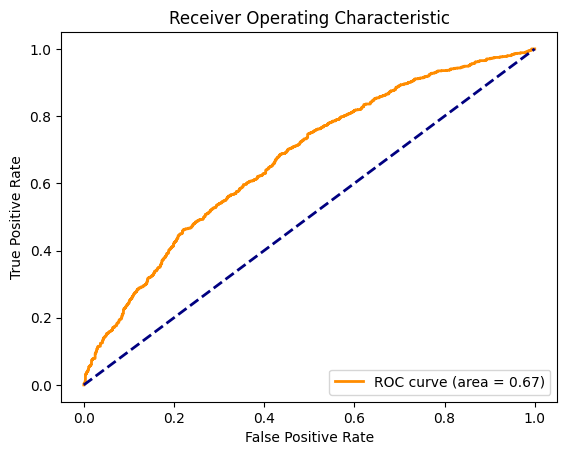

In [13]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Predict probabilities for the test set
y_test_prob = ensemble.predict_proba(X_test_scaled)

fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')# Drop any unnamed columns (columns with no header) if they exist
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


# Add predictions to original dataframe
#df['prediction'] = ensemble.predict(embeddings)
#df['prediction'] = df['prediction'].apply(lambda x: 'real' if x == 1 else 'fake')

# Save results
df.to_csv('gpt_liarcombined.csv', index=False)


In [14]:
import pandas as pd

# Save ROC curve data
roc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_data.to_csv('roc_data_gpt_liar.csv', index=False)

# Save ROC AUC
with open('roc_auc_gpt_liar.txt', 'w') as f:
    f.write(str(roc_auc))